<a href="https://colab.research.google.com/github/spongebob03/Fastai_tutorial/blob/main/fastai_ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델에서 제품까지

## 데이터 다운로드
빙 이미지 검색은 보안키를 요구해서...fastai공식 자료들을 찾아보니 귀찮게 보안키를 요구하지 않는 DuckDuckGo 이미지를 편하게 받아서 쓸 수 있는 방법이 있었습니다! 
(https://course.fast.ai/images 참고)

In [1]:
!pip install fastbook

     |████████████████████████████████| 720 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.7 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 189 kB 49.4 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 51 kB 300 kB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastbook import * 
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls), urls[0]

(100,
 'https://www.publicdomainpictures.net/pictures/90000/velka/grizzly-bear-portrait.jpg')

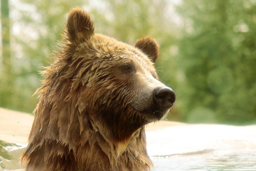

In [3]:
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

In [4]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        download_images(dest, urls=search_images_ddg(f'{o} bear', max_images=100))

In [5]:
fns = get_image_files(path)
fns[:5]

(#5) [Path('bears/grizzly/00000026.jpg'),Path('bears/grizzly/00000068.jpg'),Path('bears/grizzly/00000057.jpg'),Path('bears/grizzly/00000023.jpg'),Path('bears/grizzly/00000089.jpg')]

In [6]:
failed = verify_images(fns)
failed

(#1) [Path('bears/teddy/00000031.png')]

In [7]:
failed.map(Path.unlink)

(#1) [None]

## 데이터에서 DataLoaders까지

In [8]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train, valid = add_props(lambda i, self: self[i])

In [9]:
bears = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_y=parent_label,
                  item_tfms=Resize(128))

In [10]:
dls = bears.dataloaders(path)

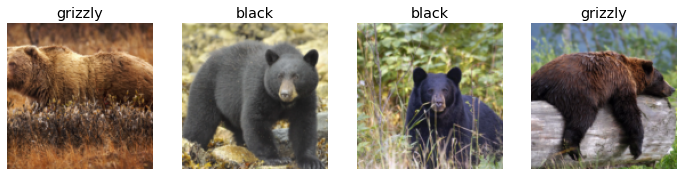

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

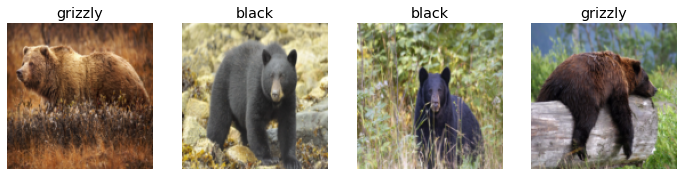

In [13]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

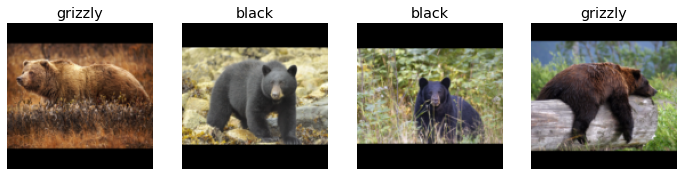

In [14]:
bears=bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

이미지 증강

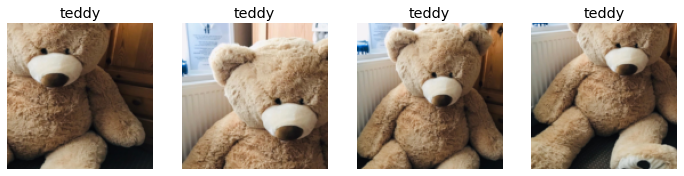

In [15]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls=bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


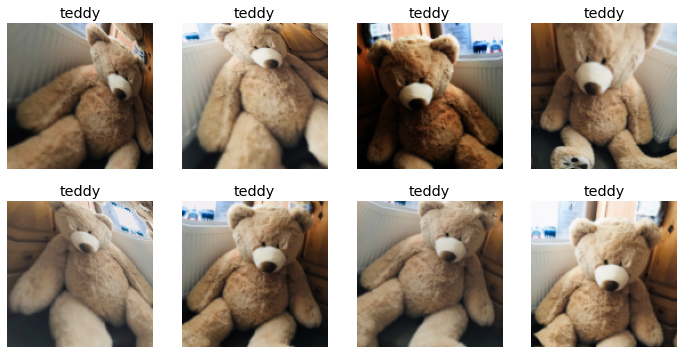

In [16]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## 모델 훈련과 훈련된 모델을 이용한 데이터 정리

In [17]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                  batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.386409,0.500404,0.224138,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.340410,0.159946,0.068965,00:22
1,0.204231,0.087402,0.034483,00:22
2,0.148788,0.047643,0.017241,00:22
3,0.113522,0.041997,0.017241,00:22


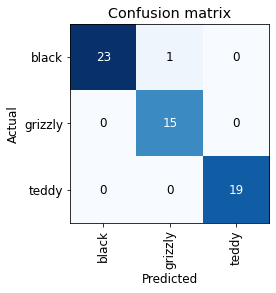

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

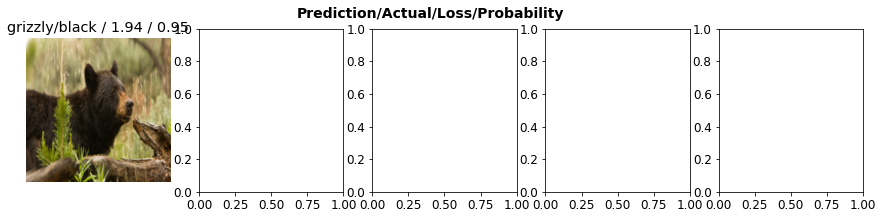

In [23]:
interp.plot_top_losses(5, nrows=1)

In [32]:
!pip install fastai2

     |████████████████████████████████| 179 kB 4.1 MB/s 


In [34]:
from fastai2.vision.widgets import *
from utils import *.

NameError: ignored

### Issue: ImageClassifierCleaner 이미지 위젯 콜랩에서 호출 불가
[Fastai2’s ImageClassifierCleaner to clean image data is not showing up in Colab](https://forums.fast.ai/t/fastai2s-imageclassifiercleaner-to-clean-image-data-is-not-showing-up-in-colab/66125)

In [28]:
cleaner = ImageClassifierCleaner(learn)
cleaner

NameError: ignored

In [ ]:
for idx in cleaner.delete():cleaner.fns[idx].unlink()

In [35]:
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

NameError: ignored

## 모델을 온라인 애플리케이션으로 전환하기

In [36]:
learn.export()

In [37]:
path = Path()

In [38]:
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### 추론

load_learner 에러   
https://forums.fast.ai/t/load-learner-for-export-pkl-not-found/34150

In [48]:
!pip install --upgrade git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-qieiqijc
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-qieiqijc
  Created wheel for fastai: filename=fastai-2.5.4-py3-none-any.whl size=187080 sha256=93b5f31cc18bd0584ebfe33e2af4acde931c88d5b8c27ebae2a714377f128bbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-388_sk7y/wheels/e2/81/30/9d0af3c5b8212ceb1118de039a8973c37f047102062f346d19
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 2.5.3
    Uninstalling fastai-2.5.3:
      Successfully uninstalled fastai-2.5.3


In [50]:
learn_inf = load_learner(path, 'export.pkl')

IsADirectoryError: ignored

In [57]:
import pickle
with open('/content/export.pkl', "rb") as fh:
  learn_inf = pickle.load(fh)

UnpicklingError: ignored

## 어플리케이션에 모델 서빙

In [51]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [52]:
img = PILImage.create(btn_upload.data[-1])

In [53]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [ ]:
pred, pred_idx, probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [ ]:
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])